In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
import scipy
import torch
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import base_network as base_net
import ring_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(imsh, cax=cax, orientation='vertical')
    return cbar

# Build Test Network

In [164]:
ri = ric.Ricciardi()
ri.set_up_nonlinearity('./../scripts/phi_int')
ri.set_up_nonlinearity_tensor()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NtE = 50
Nt = NtE*ri.tE
dt = ri.tI/5
T = torch.linspace(0,5*Nt,round(5*Nt/dt)+1)
mask_time = T>(4*Nt)
T_mask = T.cpu().numpy()[mask_time]

N = 6000
Nori = 20
NE = 12*(N//Nori)//15
NP = 2*(N//Nori)//15
NS = 1*(N//Nori)//15

W = 1e-3*np.array([[0.15,-1,-0.2],[1.0,-3,-0.5],[0.25,-0.5,0.0]])
sW = np.array([[30,20,20],[30,20,20],[15,10,20]])
H = np.array([0.25,0.3,0.00])
sH = 20*np.ones(3)
K = 500
CVh = 0.2

reload(network)

net = network.RingNetwork(NC=[NE,NP,NS],Nori=Nori)
net.generate_disorder(W,sW,H,sH,500)
net.generate_tensors()

B = np.zeros(net.N,dtype=np.float32)
B[net.C_all[0]] = H[0]
B[net.C_all[1]] = H[1]
B_torch = torch.from_numpy(B).to(device)

Eps = np.random.default_rng(0).gamma(1/CVh**2,scale=CVh**2,size=net.N).astype(np.float32)
Eps_torch = torch.from_numpy(Eps).to(device)

E_cond = torch.logical_or(net.C_conds[0],net.C_conds[2]).to(device)

Inp = 30*(0.2*B+0.8*net.H)*Eps
Inp_torch = 30*(0.2*B_torch+0.8*net.H_torch)*Eps_torch

Loading previously saved nonlinearity
Using cpu
Using cpu


In [165]:
start = time.process_time()

sol,_ = integ.sim_dyn_tensor(ri,T,0.0,net.M_torch,Inp_torch,net.H_torch,E_cond,
                             mult_tau=True,max_min=30)

print('integration took {:.3f} s'.format(time.process_time() - start))

dynas = sol[:,mask_time].numpy()
rates = np.mean(sol[:,mask_time].numpy(),-1)

integration took 79.310 s


58.89462
71.73702


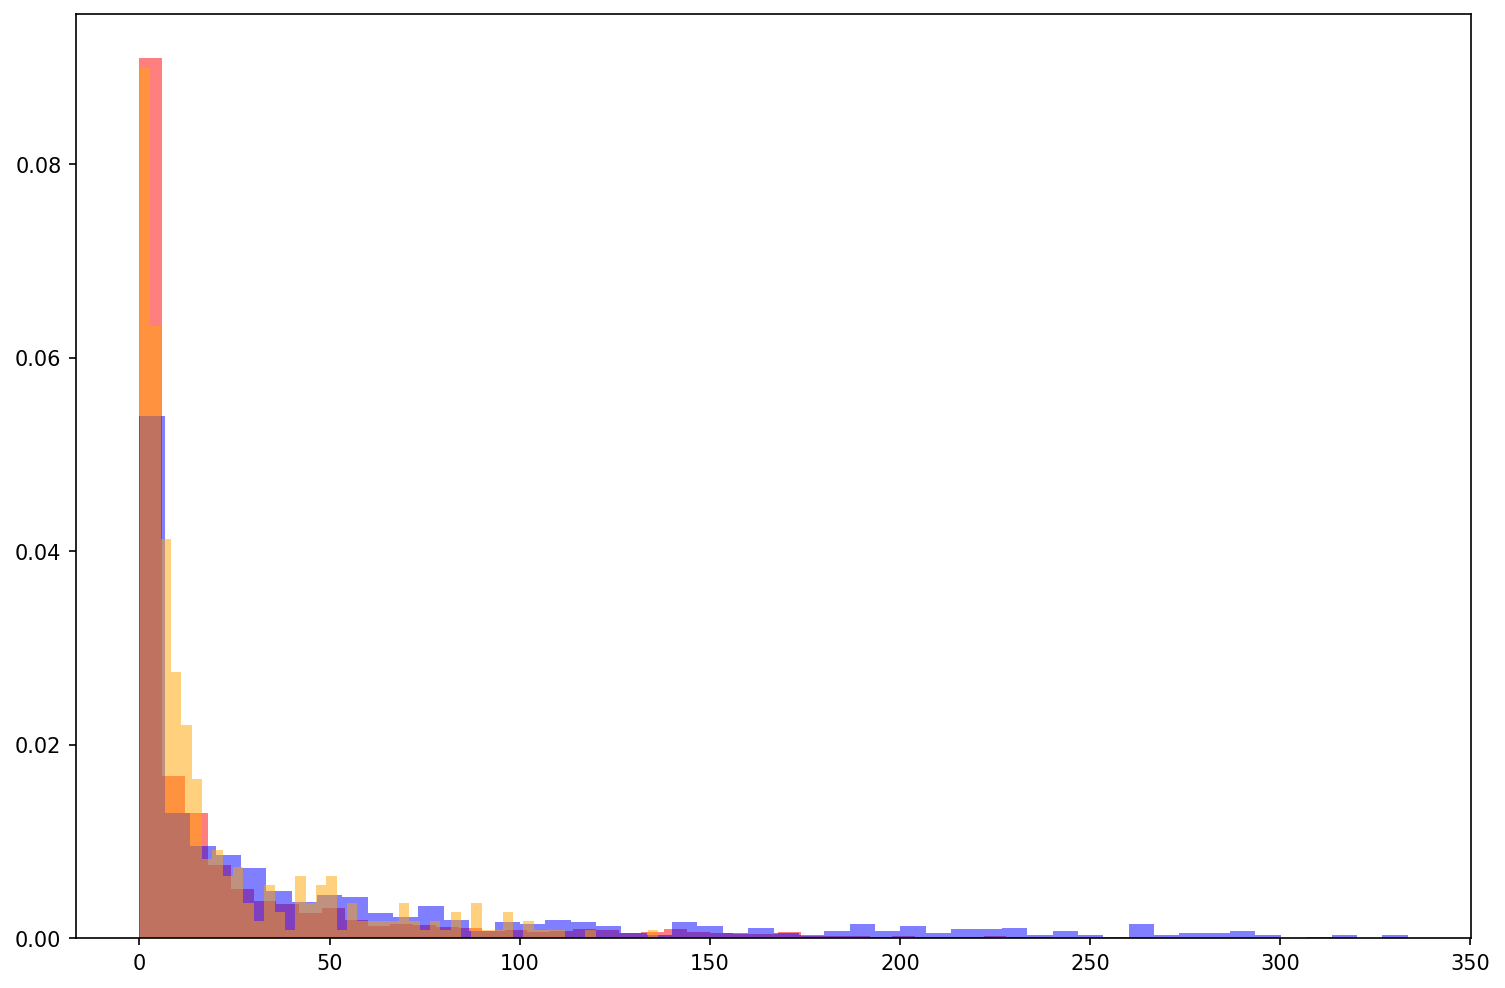

In [166]:
print(np.mean(rates[net.get_oriented_neurons()]))
print(np.std(rates[net.get_oriented_neurons()]))

fig,ax = plt.subplots(1,1,figsize=(12,8),dpi=150)

ax.hist(sol[net.C_all[0],-1],50,color='r',alpha=0.5,density=True)
ax.hist(sol[net.C_all[1],-1],50,color='b',alpha=0.5,density=True)
ax.hist(sol[net.C_all[2],-1],50,color='orange',alpha=0.5,density=True)

plt.show()

In [167]:
rate_means = np.zeros((3,Nori))
rate_stds = np.zeros((3,Nori))

for cidx in range(3):
    for oriidx in range(Nori):
        rate_means[cidx,oriidx] = np.mean(rates[net.C_idxs[cidx][oriidx]])
        rate_stds[cidx,oriidx] = np.std(rates[net.C_idxs[cidx][oriidx]])
        
oris = np.arange(Nori)*180/Nori

Text(0, 0.5, 'Std Rate')

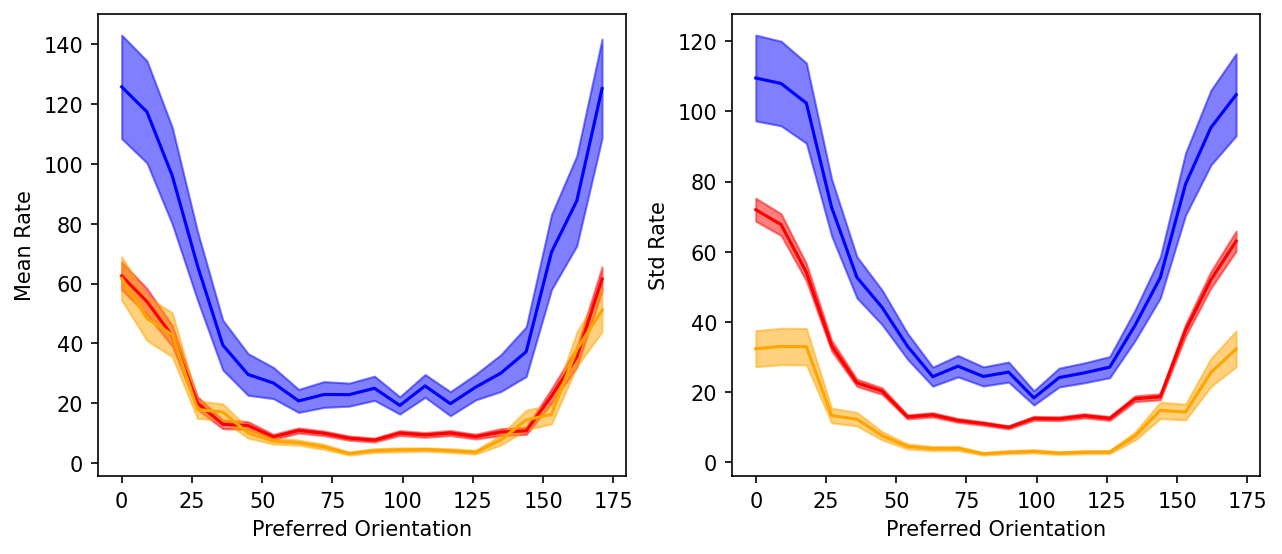

In [168]:
fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150,sharex=True)

for cidx in range(3):
    axs[0].plot(oris,rate_means[cidx],['r','b','orange'][cidx])
    axs[0].fill_between(oris,
                    rate_means[cidx]+rate_stds[cidx]/np.sqrt(net.NC[cidx]),
                    rate_means[cidx]-rate_stds[cidx]/np.sqrt(net.NC[cidx]),color=['r','b','orange'][cidx],alpha=0.5)
    
    axs[1].plot(oris,rate_stds[cidx],['r','b','orange'][cidx])
    axs[1].fill_between(oris,
                    rate_stds[cidx]+rate_stds[cidx]/np.sqrt(2*net.NC[cidx]),
                    rate_stds[cidx]-rate_stds[cidx]/np.sqrt(2*net.NC[cidx]),color=['r','b','orange'][cidx],alpha=0.5)
    
axs[0].set_xlabel('Preferred Orientation')
axs[1].set_xlabel('Preferred Orientation')
axs[0].set_ylabel('Mean Rate')
axs[1].set_ylabel('Std Rate')